In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Load stopwords once
nltk.download('stopwords')
nltk.download('punkt')
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acnel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acnel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Read the CSV file
data = pd.read_csv("D:/Andre/masters/DataAnalysis/additionalAssignment/arxiv2017.csv",
                    delimiter=';',
                    nrows=3000)
# Add the 'Title' column to the 'Abstract' column and store it in a new column 'combined_text'
data['combined_text'] = data['Title'] + ' ' + data['Abstract']

In [14]:
def preprocess_data(columnToClean: str, cleanedColumnName: str,
                    selected_subjects: list, numClusters) -> pd.DataFrame:
    """
    Filter it by selected subjects, and preprocess the text.
    
    Args:
        selected_subjects (list): List of subject areas to filter the data.
        
    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    # Filter data by selected subjects
    filtered_data = data[data['Subject_area'].isin(selected_subjects)]

    # Preprocess the text
    def preprocess_text(text: str, remove_stopwords: bool = True) -> str:
        """
        Preprocess text by removing links, special characters, numbers, and optionally stopwords.
        
        Args:
            text (str): Input text.
            remove_stopwords (bool): Whether to remove stopwords (default True).
            
        Returns:
            str: Preprocessed text.
        """
        # Lemmentization did not improve the results

        text = re.sub(r"http\S+", "", text)  # Remove links
        # text = re.sub("[^A-Za-z]+", " ", text)  # Remove special characters and numbers
        if remove_stopwords:
            tokens = nltk.word_tokenize(text)  # Tokenize
            tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]  # Remove stopwords
            text = " ".join(tokens)  # Join tokens
        text = text.lower().strip()  # Convert to lowercase and remove whitespace
        return text

    # Apply text preprocessing to the column to clean
    filtered_data[cleanedColumnName] = filtered_data[columnToClean].apply(
        lambda x: preprocess_text(x, remove_stopwords=True))

    # Save the filtered DataFrame to a CSV file
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"./filtered_data/{numClusters}_clusters_{timestamp}.csv"

    filtered_data.to_csv(filename, index=False)

    return filtered_data

In [4]:
# what categories are available? and how many?
df = data.copy()
categories = df['Subject_area'].unique()
print(len(categories))
categories

39


array(['LO', 'LG', 'NI', 'CG', 'DB', 'CE', 'DM', 'MS', 'CR', 'CL', 'IT',
       'DS', 'CC', 'AI', 'GT', 'CV', 'PF', 'FL', 'SI', 'DC', 'HC', 'PL',
       'IR', 'OH', 'SE', 'CY', 'RO', 'DL', 'NE', 'GR', 'MA', 'MM', 'AR',
       'SY', nan, 'SC', 'ET', 'SD', 'OS'], dtype=object)

In [9]:
# List of selected subjects
selected_subjects = ['LO', 'LG']
columnToClean='combined_text'
cleanedColumnName='cleaned'
numClusters = len(selected_subjects)

In [10]:
# Preprocess data
filtered_data = preprocess_data(columnToClean=columnToClean,
                                cleanedColumnName=cleanedColumnName,
                                selected_subjects=selected_subjects,
                                numClusters=numClusters)


NameError: name 'preprocess_data' is not defined

In [15]:
filtered_data = pd.read_csv('D:/Andre/masters/DataAnalysis/additionalAssignment/partB/filtered_data/5_clusters_2024-01-02_21-56-37.csv')

In [16]:
filtered_data.shape

(749, 7)

In [17]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(filtered_data['Subject_area'])

In [18]:
minOccurrences = int(filtered_data.shape[0]*0.005)
minOccurrences

3

In [19]:

# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=minOccurrences, max_df=0.85)

X_tfidf = vectorizer.fit_transform(filtered_data[cleanedColumnName])

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from time import time

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)

In [21]:
maxClusters = numClusters*2
maxClusters

4

In [22]:
maxClusters = 3

In [23]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import multiprocessing as mp

def evaluate_gmm_cluster(data, n_clusters, run):
    """
    Evaluate a single clustering run using Gaussian Mixture Model.

    Args:
        data (np.array): The data to be clustered.
        n_clusters (int): Number of clusters for Gaussian Mixture.
        run (int): Seed for random state in Gaussian Mixture.

    Returns:
        tuple: silhouette score, AIC score, BIC score for the run.
    """
    gm = GaussianMixture(n_components=n_clusters, max_iter=100, n_init=30, random_state=run)
    labels = gm.fit_predict(data)
    return silhouette_score(data, labels), gm.aic(data), gm.bic(data)


def find_optimal_clusters_silhouette(data, max_clusters=20, n_runs=5):
    """
    Determine the optimal number of clusters using averaged performance metrics over multiple runs.

    Args:
        data (np.array): The data to be clustered.
        max_clusters (int): The maximum number of clusters to try.
        n_runs (int): The number of runs for each number of clusters to average the metrics.

    Returns:
        int: Optimal number of clusters.
    """
    avg_silhouette_scores = []
    avg_aic_scores = []
    avg_bic_scores = []

    # Use a specific multiprocessing context
    context = mp.get_context("spawn")
    with context.Pool(mp.cpu_count()) as pool:
        for n_clusters in range(2, max_clusters + 1):
            print(f"Processing {n_clusters} clusters...")
            tasks = [(data, n_clusters, run) for run in range(n_runs)]
            results = pool.starmap(evaluate_gmm_cluster, tasks)

            silhouette_scores, aic_scores, bic_scores = zip(*results)

            # Averaging the scores over the runs
            avg_silhouette_scores.append(np.mean(silhouette_scores))
            avg_aic_scores.append(np.mean(aic_scores))
            avg_bic_scores.append(np.mean(bic_scores))

            print(f"Clusters: {n_clusters}, Avg Silhouette: {np.mean(silhouette_scores):.3f}, Avg AIC: {np.mean(aic_scores):.3f}, Avg BIC: {np.mean(bic_scores):.3f}")

    # Plotting the results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(range(2, max_clusters + 1), avg_silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Average Silhouette Score')
    plt.title('Average Silhouette Score vs. Number of Clusters')

    plt.subplot(1, 3, 2)
    plt.plot(range(2, max_clusters + 1), avg_aic_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Average AIC Score')
    plt.title('Average AIC vs. Number of Clusters')

    plt.subplot(1, 3, 3)
    plt.plot(range(2, max_clusters + 1), avg_bic_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Average BIC Score')
    plt.title('Average BIC vs. Number of Clusters')

    plt.tight_layout()

    # Saving the plot with a date-time stamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"optimalClusters/Silhouette_{timestamp}.png"
    plt.savefig(filename)
    plt.show()

    # Choosing the optimal number of clusters based on the highest average silhouette score
    optimal_clusters = range(2, max_clusters + 1)[np.argmax(avg_silhouette_scores)]
    print(f"Optimal number of clusters based on average Silhouette Score: {optimal_clusters}")

    return optimal_clusters

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from datetime import datetime
from typing import Tuple, List
import multiprocessing as mp

def fit_gmm(X: np.array, n_clusters: int) -> float:
    """
    Fit Gaussian Mixture Model and return the log-likelihood.

    Args:
        X (np.array): The data to be clustered.
        n_clusters (int): Number of clusters for Gaussian Mixture.

    Returns:
        float: Log-likelihood of the model.
    """
    gmm = GaussianMixture(n_components=n_clusters, max_iter=100, n_init=30)
    gmm.fit(X)
    return gmm.score(X)

def worker_function(X: np.array, n_clusters: int) -> float:
    """
    Worker function to be used in multiprocessing pool.

    Args:
        X (np.array): The data to be clustered.
        n_clusters (int): Number of clusters to fit the GMM.

    Returns:
        float: The log-likelihood of the fitted GMM.
    """
    return fit_gmm(X, n_clusters)

def optimal_clusters_gmm_modified_elbow(X: np.array, max_clusters: int, plot: bool = True) -> Tuple[int, List[float], str]:
    """
    Determine the optimal number of clusters using a modified elbow method for Gaussian Mixture Models.

    Args:
        X (np.array): The data to be clustered.
        max_clusters (int): The maximum number of clusters to try.
        plot (bool): Whether to plot the log-likelihood graph. Defaults to True.

    Returns:
        Tuple[int, List[float], str]: Optimal number of clusters, log-likelihoods, and plot file name.
    """
    if max_clusters < 1:
        raise ValueError("maxClusters must be a positive integer")

    rangeClusters = range(1, max_clusters + 1)

    with mp.Pool(mp.cpu_count()) as pool:
        # Create a list of arguments for each process
        tasks = [(X, n) for n in rangeClusters]
        logLikelihoods = pool.starmap(worker_function, tasks)

    # Automated Elbow Detection (simple approach)
    optimalClusters = max_clusters
    if len(logLikelihoods) > 2:
        deltas = np.diff(logLikelihoods)
        optimalClusters = np.argmax(deltas) + 1

    filename = ""
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(rangeClusters, logLikelihoods, marker='o')
        plt.axvline(x=optimalClusters, color='red',
                    linestyle='--',
                    label=f'Optimal Clusters: {optimalClusters}')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Log-Likelihood')
        plt.title('GMM Log-Likelihood vs. Number of Clusters')
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"optimalClusters/logLikelihood_{timestamp}.png"
        plt.savefig(filename)
        plt.show()

    return optimalClusters, logLikelihoods, filename

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime
from typing import Tuple, List
import multiprocessing as mp

def fit_kmeans(X: np.ndarray, n_clusters: int) -> float:
    """
    Fit KMeans and return the within-cluster sum of squares (WCSS).

    Args:
        X (np.ndarray): The data to be clustered.
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        float: WCSS for the model.
    """
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

def find_optimal_clusters_kmeans(X: np.ndarray, max_clusters: int, plot: bool = True) -> Tuple[int, List[float], str]:
    """
    Determine the optimal number of clusters for K-Means using a modified elbow method.

    Args:
        X (np.ndarray): The data to be clustered.
        max_clusters (int): The maximum number of clusters to try.
        plot (bool): Whether to plot the WCSS graph. Defaults to True.

    Returns:
        Tuple[int, List[float], str]: Optimal number of clusters, WCSS values, and plot file name.
    """
    if max_clusters < 1:
        raise ValueError("maxClusters must be at least 1.")

    rangeClusters = range(1, max_clusters + 1)

    with mp.Pool(mp.cpu_count()) as pool:
        wcss = pool.map(lambda n: fit_kmeans(X, n), rangeClusters)

    # Automated Elbow Detection
    optimalClusters = maxClusters
    if len(wcss) > 2:
        deltas = np.diff(wcss)
        optimalClusters = np.argmin(deltas) + 1

    filename = ""
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(rangeClusters, wcss, marker='o')
        plt.axvline(x=optimalClusters, color='red', linestyle='--', label=f'Optimal Clusters: {optimalClusters}')
        plt.xlabel('Number of Clusters')
        plt.ylabel('WCSS')
        plt.title('K-Means WCSS vs. Number of Clusters')
        plt.legend()
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"KMeans_elbow_method_{timestamp}.png"
        plt.savefig(filename)
        plt.show()

    return optimalClusters, wcss, filename

In [26]:
numClustersSilhouette = find_optimal_clusters_silhouette(X_lsa,
                                                      max_clusters=maxClusters,
                                                      n_runs=7)
numClustersSilhouette

In [37]:
optimal_clusters_gmm_modified_elbow(X_lsa, max_clusters=maxClusters)

In [ ]:
find_optimal_clusters_kmeans(X_lsa, max_clusters=maxClusters)

In [ ]:
chosenNumberClusters = 10

c:\Users\Jakne\Desktop\Andre\AdditionalAssignment\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
gm = GaussianMixture(
    n_components=chosenNumberClusters,
    max_iter=100,
    n_init=30,
)
gm.fit(X_lsa)

probabilities = gm.predict_proba(X_lsa)

In [ ]:
def plot_cluster_heatmap_filtered(probabilities, lower_bound=0.05, upper_bound=0.95):
    """
    Plot a heatmap of document-cluster probabilities, excluding values close to 0 or 1.

    Args:
        probabilities (np.ndarray): Probabilities of documents belonging to each cluster.
        lower_bound (float): Lower bound for filtering probabilities.
        upper_bound (float): Upper bound for filtering probabilities.
    """
    # Create a mask for values close to 0 or 1
    mask = np.logical_or(probabilities <= lower_bound,
                         probabilities >= upper_bound)

    plt.figure(figsize=(12, 8))
    sns.heatmap(probabilities, mask=mask, cmap='viridis')
    plt.title("Filtered Heatmap of Document-Cluster Probabilities")
    plt.ylabel("Document Index")
    plt.xlabel("Cluster Index")
    plt.show()

In [ ]:
# Call the function with the probabilities
plot_cluster_heatmap_filtered(probabilities, 0.005, 0.995)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from collections import defaultdict
from time import time
import numpy as np

def fitAndEvaluateGM(gm: GaussianMixture, x: np.ndarray, labels: np.ndarray, name: str = None, nRuns: int = 5) -> tuple[list[dict], list[dict]]:
    """
    Fit the Gaussian Mixture model and evaluate its performance.

    Args:
        gm (GaussianMixture): The Gaussian Mixture model to be fitted and evaluated.
        x (np.ndarray): The data to fit the model to.
        labels (np.ndarray): The true labels for the data.
        name (str, optional): The name of the estimator. Defaults to the class name of `gm` if None.
        nRuns (int, optional): The number of times to run the fitting for different seeds. Defaults to 5.

    Raises:
        TypeError: If `x` or `labels` is not a numpy ndarray.

    Returns:
        tuple[list[dict], list[dict]]: Two lists of dictionaries containing evaluation metrics and their standard deviations.

    """
    if not isinstance(x, np.ndarray):
        raise TypeError("Expected x to be a numpy ndarray")
    if not isinstance(labels, np.ndarray):
        raise TypeError("Expected labels to be a numpy ndarray")

    evaluations = []
    evaluationsStd = []
    
    name = gm.__class__.__name__ if name is None else name

    trainTimes = []
    scores = defaultdict(list)
    for seed in range(nRuns):
        gm.set_params(random_state=seed)
        t0 = time()
        gm.fit(x)
        trainTimes.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, gm.predict(x)))
        scores["Completeness"].append(metrics.completeness_score(labels, gm.predict(x)))
        scores["V-measure"].append(metrics.v_measure_score(labels, gm.predict(x)))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, gm.predict(x)))
        scores["Normalized Mutual Info"].append(metrics.normalized_mutual_info_score(labels, gm.predict(x)))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(x, gm.predict(x), sample_size=2000))
    trainTimes = np.asarray(trainTimes)

    print(f"clustering done in {trainTimes.mean():.2f} ± {trainTimes.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": trainTimes.mean(),
    }
    evaluationStd = {
        "estimator": name,
        "train_time": trainTimes.std(),
    }
    for scoreName, scoreValues in scores.items():
        meanScore, stdScore = np.mean(scoreValues), np.std(scoreValues)
        print(f"{scoreName}: {meanScore:.3f} ± {stdScore:.3f}")
        evaluation[scoreName] = meanScore
        evaluationStd[scoreName] = stdScore
    evaluations.append(evaluation)
    evaluationsStd.append(evaluationStd)

    return evaluations, evaluationsStd

In [ ]:
fitAndEvaluateGM(gm, X_lsa, labels=true_labels,
                 name="gm\nwith LSA on tf-idf vectors")

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.mixture import GaussianMixture
import numpy as np

def printGMClusterTerms(lsa: TruncatedSVD, gm: GaussianMixture, vectorizer: CountVectorizer, numClusters: int) -> None:
    """
    Print the top terms in each cluster.

    Args:
        lsa (TruncatedSVD): The fitted LSA (Latent Semantic Analysis) model.
        gm (GaussianMixture): The fitted Gaussian Mixture model.
        vectorizer (CountVectorizer): The vectorizer used to fit the LSA model.
        numClusters (int): The number of clusters.

    Raises:
        TypeError: If any of the inputs are not of the expected type.
    """
    if not isinstance(lsa[0], TruncatedSVD):
        raise TypeError("Expected lsa to be an instance of TruncatedSVD")
    if not isinstance(gm, GaussianMixture):
        raise TypeError("Expected gm to be an instance of GaussianMixture")
    if not isinstance(vectorizer, CountVectorizer):
        raise TypeError("Expected vectorizer to be an instance of CountVectorizer")
    if not isinstance(numClusters, int):
        raise TypeError("Expected numClusters to be an integer")

    originalSpaceCentroids = lsa[0].inverse_transform(gm.means_)
    orderCentroids = originalSpaceCentroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(numClusters):
        print(f"Cluster {i}: ", end="")
        for ind in orderCentroids[i, :10]:
            print(f"{terms[ind]} ", end="")
        print()

In [ ]:
printGMClusterTerms(lsa, gm, vectorizer, numClusters)

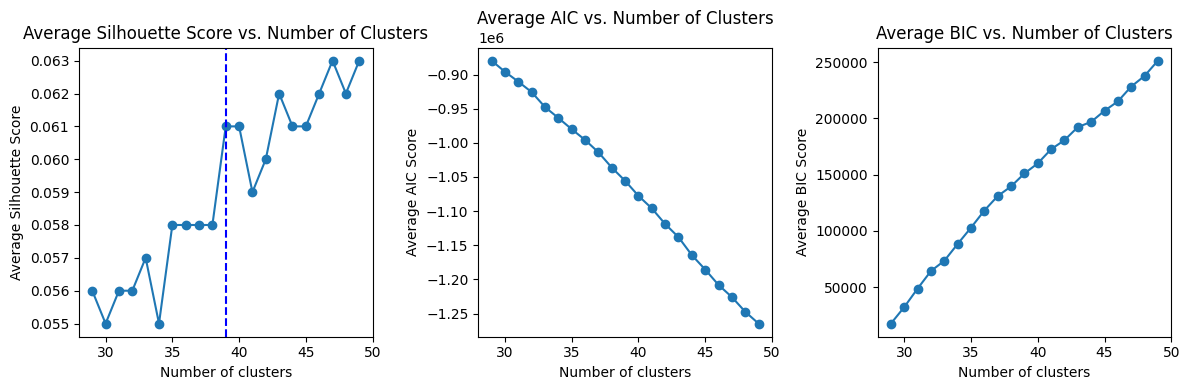

Optimal number of clusters based on average Silhouette Score: 47


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


actualOptimalClusters = 39
min_clusters = 29
max_clusters = 49
avg_silhouette_scores = [0.056,
                            0.055,
                            0.056,
                            0.056,
                            0.057,
                            0.055,
                            0.058,
                            0.058,
                            0.058,
                            0.058,
                            0.061,
                            0.061,
                            0.059,
                            0.060,
                            0.062,
                            0.061,
                            0.061,
                            0.062,
                            0.063,
                            0.062,
                            0.063,]
avg_aic_scores = [
    -879669.059,
    -895922.468,
    -910397.806,
    -925726.805,
    -947581.123,
    -963557.128,
    -980005.792,
    -995707.131,
    -1013790.234,
    -1036135.270,
    -1055589.021,
    -1077554.892,
    -1095909.925,
    -1118808.565,
    -1138096.862,
    -1164385.406,
    -1185468.085,
    -1208075.061,
    -1225807.196,
    -1247304.675,
    -1264642.511,
]
avg_bic_scores = [
    17550.116,
    32235.506,
    48698.967,
    64308.767,
    73393.249,
    88356.043,
    102846.178,
    118083.639,
    130939.335,
    139533.098,
    151018.147,
    159991.076,
    172574.842,
    180615.001,
    192265.503,
    196915.759,
    206771.879,
    215103.702,
    228310.367,
    237751.687,
    251352.650
]

# Plotting the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(min_clusters, max_clusters + 1),
            avg_silhouette_scores, marker='o')
if actualOptimalClusters is not None:
    plt.axvline(x=actualOptimalClusters, color='blue',
                linestyle='--',
                label=f'Optimal Clusters: {actualOptimalClusters}')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. Number of Clusters')

plt.subplot(1, 3, 2)
plt.plot(range(min_clusters, max_clusters + 1), avg_aic_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average AIC Score')
plt.title('Average AIC vs. Number of Clusters')

plt.subplot(1, 3, 3)
plt.plot(range(min_clusters, max_clusters + 1), avg_bic_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average BIC Score')
plt.title('Average BIC vs. Number of Clusters')

plt.tight_layout()

# Saving the plot with a date-time stamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"optimalClusters/Silhouette_{timestamp}.png"
plt.savefig(filename)
plt.show()

# Choosing the optimal number of clusters based on the highest average silhouette score
optimal_clusters = range(
    min_clusters, max_clusters + 1)[np.argmax(avg_silhouette_scores)]
print(
    f"Optimal number of clusters based on average Silhouette Score: {optimal_clusters}")